In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gensim==3.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 55.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.0-cp39-cp39-linux_x86_64.whl size=24952703 sha256=9dc96405b243e054677a1b59bda94d4e800a8e57bb0e4b7e8b794563c6705998
  Stored in directory: /root/.cache/pip/wheels/fb/18/fa/2a0084905c1be0cead09a515d05015c1f939afb16fd7893ff4
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1


In [3]:
from nltk.corpus import stopwords 
from collections import Counter
import nltk
nltk.download('stopwords')
import re
import seaborn as sns
from tqdm import tqdm

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torch

# CURRENT_DIR = os.getcwd()
CURRENT_DIR = "/content/drive/MyDrive/CSE582-NLP-Assignment2-986195304"
INPUT_FILE = os.path.join(CURRENT_DIR, 'output','top_data_df_small.csv')
OUTPUT_FOLDER = os.path.join(CURRENT_DIR, 'output')

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [5]:
df = pd.read_csv(INPUT_FILE)
df.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment,tokenized_text,stemmed_tokens
0,1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,1,"['ve', 'taken', 'lot', 'of', 'spin', 'classes'...","['ve', 'taken', 'lot', 'of', 'spin', 'class', ..."
1,3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,1,"['wow', 'yummy', 'different', 'delicious', 'ou...","['wow', 'yummi', 'differ', 'delici', 'our', 'f..."
2,4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,1,"['cute', 'interior', 'and', 'owner', 'gave', '...","['cute', 'interior', 'and', 'owner', 'gave', '..."
3,6,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18,1,"['loved', 'this', 'tour', 'grabbed', 'groupon'...","['love', 'thi', 'tour', 'grab', 'groupon', 'an..."
4,7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,1,"['amazingly', 'amazing', 'wings', 'and', 'home...","['amazingli', 'amaz', 'wing', 'and', 'homemad'..."


### Splitting to train and test data

We will split data to train and test initially. Doing this on earlier stage allows to avoid data lekage.


In [18]:
# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return 0
    elif stars_received == 3:
        return 0.5
    else:
        return 1

sentiment_list = [ map_sentiment(x) for x in df['stars'].values]

In [19]:
X,y = df['text'].values,sentiment_list
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (22500,)
shape of test data is (7500,)


### Analysing sentiment

### Tokenization

In [20]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

# def tockenize(x_train,y_train,x_val,y_val):
def tockenize(x_train,x_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])

    return final_list_train, final_list_test, onehot_dict


In [21]:
y_train = np.array(y_train)
y_test = np.array(y_test)
x_train,x_test,vocab = tockenize(x_train,x_test)
x_val, y_val = x_test[:int(len(x_test)/2)], y_test[:int(len(y_test)/2)]
x_test, y_test = x_test[int(len(x_test)/2):], y_test[int(len(y_test)/2):]

In [10]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Padding

Pad each of the sequence to max length 

In [23]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [44]:
#we have less number of reviews with length > 400. So we will consideronly those below it.
x_train_pad = padding_(x_train,400)
x_test_pad = padding_(x_test,400)
x_val_pad = padding_(x_val,400)

### Batching and loading as tensor

In [45]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(x_val_pad), torch.from_numpy(y_val))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [46]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 400])
Sample input: 
 tensor([[  0,   0,   0,  ..., 509, 144, 717],
        [  0,   0,   0,  ...,  59, 185,   3],
        [  0,   0,   0,  ...,  95,   7, 299],
        ...,
        [  0,   0,   0,  ...,  53,  12,  11],
        [  0,   0,   0,  ..., 684, 148, 179],
        [  0,   0,   0,  ...,  18, 169,   1]])
Sample input: 
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.5000, 0.0000,
        1.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000, 1.0000, 0.5000,
        0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 1.0000, 0.0000, 0.5000], dtype=torch.float64)


### Model with TanH as Activation

In [39]:
import gensim
class SentimentLSTM(nn.Module):
    
    def __init__(self, n_embed, n_hidden, n_output, n_layers, drop_p = 0.5):
        super().__init__()
        # params: "n_" means dimension of the variable
        self.n_layers = n_layers   # number of LSTM layers 
        self.n_hidden = n_hidden   # number of hidden nodes in LSTM

         # embedding and LSTM layers
        # w2vmodel = gensim.models.KeyedVectors.load(os.path.join(OUTPUT_FOLDER, 'models', 'word2vec_500_PAD.model'))
        # weights = w2vmodel.wv
        # self.n_vocab = len(w2vmodel.wv.vocab)
        # self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        
        self.embedding = nn.Embedding(len(vocab) + 1, n_embed)
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, dropout = drop_p)
        self.dropout = nn.Dropout(drop_p)
        self.fc = nn.Linear(n_hidden, n_output)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
    def forward (self, input_words,hidden):
                                             # INPUT   :  (batch_size, seq_length)
        embedded_words = self.embedding(input_words)    # (batch_size, seq_length, n_embed)
        lstm_out, h = self.lstm(embedded_words,hidden)         # (batch_size, seq_length, n_hidden)
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.tanh(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.n_hidden) # (batch_size*seq_length, n_hidden)
        fc_out = self.fc(lstm_out)                      # (batch_size*seq_length, n_output)
        sigmoid_out = self.sigmoid(fc_out)              # (batch_size*seq_length, n_output)
        sigmoid_out = sigmoid_out.view(batch_size, -1)  # (batch_size, seq_length*n_output)
        
        # extract the output of ONLY the LAST output of the LAST element of the sequence
        sigmoid_out = sigmoid_out[:, -1]               # (batch_size, 1)
        
        return sigmoid_out, h

    def init_hidden (self, batch_size):  # initialize hidden weights (h,c) to 0
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        weights = next(self.parameters()).data
        h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
             weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        
        return h

### Training

In [40]:
no_layers = 2
embedding_dim = 64
output_dim = 1
hidden_dim = 512

model = SentimentLSTM(embedding_dim, hidden_dim, output_dim, no_layers)

#moving to gpu
model.to(device)

print(model)

print("Total parameters:", sum(p.numel() for p in model.parameters()))
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
)
Total parameters: 3349569
Trainable parameters: 3349569


In [41]:
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs|
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
import time
for epoch in range(epochs):
    start_time = time.time()
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())

        loss.backward()
        train_losses.append(loss.item())
        
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy

        optimizer.step()
  
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    end_time = time.time()
    print("Epoch : " + str(epoch + 1))
    print(f'Train Loss : {epoch_train_loss}')
    print(f'Val Loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print("Time taken :"+ str(time.time() - start_time))
    if epoch_val_loss <= valid_loss_min:
        torch.save(model, os.path.join(OUTPUT_FOLDER, 'lstm_big_model_500_with_padding_tanh.pth'))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch : 1
Train Loss : 0.6859631492031946
Val Loss : 0.6947588006655375
train_accuracy : 36.38666666666667 val_accuracy : 33.28
Time taken :63.98108100891113
Validation loss decreased (inf --> 0.694759).  Saving model ...
Epoch : 2
Train Loss : 0.6397854750023948
Val Loss : 0.5636896347999573
train_accuracy : 44.51555555555556 val_accuracy : 56.506666666666675
Time taken :63.153565406799316
Validation loss decreased (0.694759 --> 0.563690).  Saving model ...
Epoch : 3
Train Loss : 0.5063123899035984
Val Loss : 0.4828890931606293
train_accuracy : 58.608888888888885 val_accuracy : 59.49333333333333
Time taken :62.73077654838562
Validation loss decreased (0.563690 --> 0.482889).  Saving model ...
Epoch : 4
Train Loss : 0.4611846752299203
Val Loss : 0.4720272167523702
train_accuracy : 60.83555555555555 val_accuracy : 60.480000000000004
Time taken :63.53475618362427
Validation loss decreased (0.482889 --> 0.472027).  Saving model ...
Epoch : 5
Train Loss : 0.43253109213378693
Val Loss : 0.4

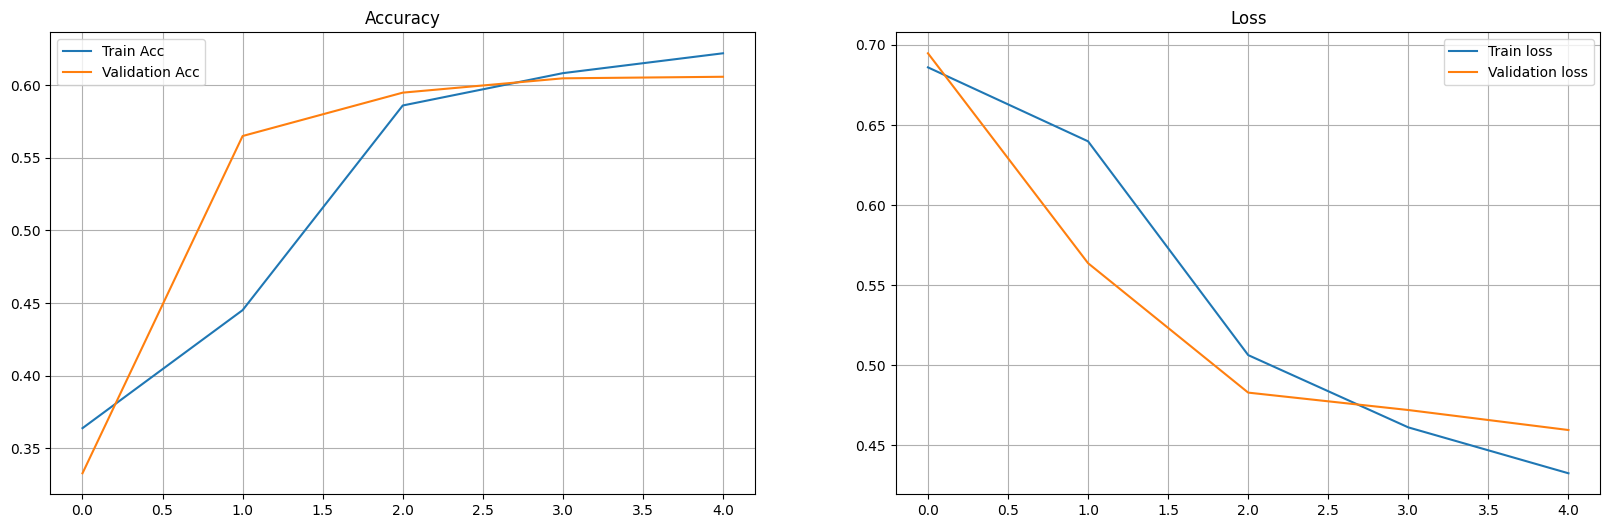

In [42]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [43]:
model.eval()
test_losses = []
num_correct = 0
with torch.no_grad():
  test_h = model.init_hidden(batch_size)
  for index, row in enumerate(test_loader):
          test_h = tuple([each.data for each in test_h])
          inputs, labels = inputs.to(device), labels.to(device)
          output, test_h = model(inputs, test_h)
          predicted = torch.round(output.squeeze())
          loss = criterion((output), (labels).float())
          test_losses.append(loss.item())
          correct_tensor = predicted.eq(labels.float().view_as(predicted))
          correct = np.squeeze(correct_tensor.cpu().numpy())
          num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 0.4234
Test Accuracy: 0.68


Model with Relu as Activation

In [32]:
import gensim
class SentimentLSTMRelu(nn.Module):
    
    def __init__(self, n_embed, n_hidden, n_output, n_layers, drop_p = 0.5):
        super().__init__()
        # params: "n_" means dimension of the variable
        self.n_layers = n_layers   # number of LSTM layers 
        self.n_hidden = n_hidden   # number of hidden nodes in LSTM

         # embedding and LSTM layers
        # w2vmodel = gensim.models.KeyedVectors.load(os.path.join(OUTPUT_FOLDER, 'models', 'word2vec_500_PAD.model'))
        # weights = w2vmodel.wv
        # self.n_vocab = len(w2vmodel.wv.vocab)
        # self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        
        self.embedding = nn.Embedding(len(vocab) + 1, n_embed)
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, dropout = drop_p)
        self.dropout = nn.Dropout(drop_p)
        self.fc = nn.Linear(n_hidden, n_output)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward (self, input_words, hidden):
                                             # INPUT   :  (batch_size, seq_length)
        embedded_words = self.embedding(input_words)    # (batch_size, seq_length, n_embed)
        lstm_out, h = self.lstm(embedded_words,hidden)         # (batch_size, seq_length, n_hidden)
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.n_hidden) # (batch_size*seq_length, n_hidden)
        lstm_out = self.relu(lstm_out)
        fc_out = self.fc(lstm_out)                      # (batch_size*seq_length, n_output)
        sigmoid_out = self.sigmoid(fc_out)              # (batch_size*seq_length, n_output)
        sigmoid_out = sigmoid_out.view(batch_size, -1)  # (batch_size, seq_length*n_output)
        
        # extract the output of ONLY the LAST output of the LAST element of the sequence
        sigmoid_out = sigmoid_out[:, -1]               # (batch_size, 1)
        
        return sigmoid_out, h

    def init_hidden (self, batch_size):  # initialize hidden weights (h,c) to 0
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        weights = next(self.parameters()).data
        h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
             weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        
        return h

In [33]:
no_layers = 2
embedding_dim = 64
output_dim = 1
hidden_dim = 512

model_relu = SentimentLSTMRelu(embedding_dim, hidden_dim, output_dim, no_layers)

#moving to gpu
model_relu.to(device)

print(model_relu)

print("Total parameters:", sum(p.numel() for p in model_relu.parameters()))
print("Trainable parameters:", sum(p.numel() for p in model_relu.parameters() if p.requires_grad))

# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model_relu.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

SentimentLSTMRelu(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)
Total parameters: 3349569
Trainable parameters: 3349569


In [34]:
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
import time
for epoch in range(epochs):
    start_time = time.time()
    train_losses = []
    train_acc = 0.0
    model_relu.train()
    # initialize hidden state 
    h = model_relu.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model_relu.zero_grad()
        output,h = model_relu(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())

        loss.backward()
        train_losses.append(loss.item())
        
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy

        optimizer.step()
  
    val_h = model_relu.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model_relu.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model_relu(inputs,val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    end_time = time.time()
    print("Epoch : " + str(epoch + 1))
    print(f'Train Loss : {epoch_train_loss}')
    print(f'Val Loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print("Time taken :"+ str(time.time() - start_time))
    if epoch_val_loss <= valid_loss_min:
        torch.save(model_relu, os.path.join(OUTPUT_FOLDER, 'lstm_big_model_500_with_padding_relu.pth'))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch : 1
Train Loss : 0.5936290619770686
Val Loss : 0.5325474699338277
train_accuracy : 51.519999999999996 val_accuracy : 56.720000000000006
Time taken :63.72289991378784
Validation loss decreased (inf --> 0.532547).  Saving model ...
Epoch : 2
Train Loss : 0.5019778353638119
Val Loss : 0.48263699253400166
train_accuracy : 58.91111111111111 val_accuracy : 59.49333333333333
Time taken :64.03036451339722
Validation loss decreased (0.532547 --> 0.482637).  Saving model ...
Epoch : 3
Train Loss : 0.4690831259886424
Val Loss : 0.4886224591732025
train_accuracy : 60.49777777777777 val_accuracy : 59.73333333333334
Time taken :63.60409998893738
Epoch : 4
Train Loss : 0.4504035779502657
Val Loss : 0.45995323260625204
train_accuracy : 61.23555555555556 val_accuracy : 60.56
Time taken :63.830732345581055
Validation loss decreased (0.482637 --> 0.459953).  Saving model ...
Epoch : 5
Train Loss : 0.42503682772318524
Val Loss : 0.4574625821908315
train_accuracy : 62.39555555555556 val_accuracy : 61

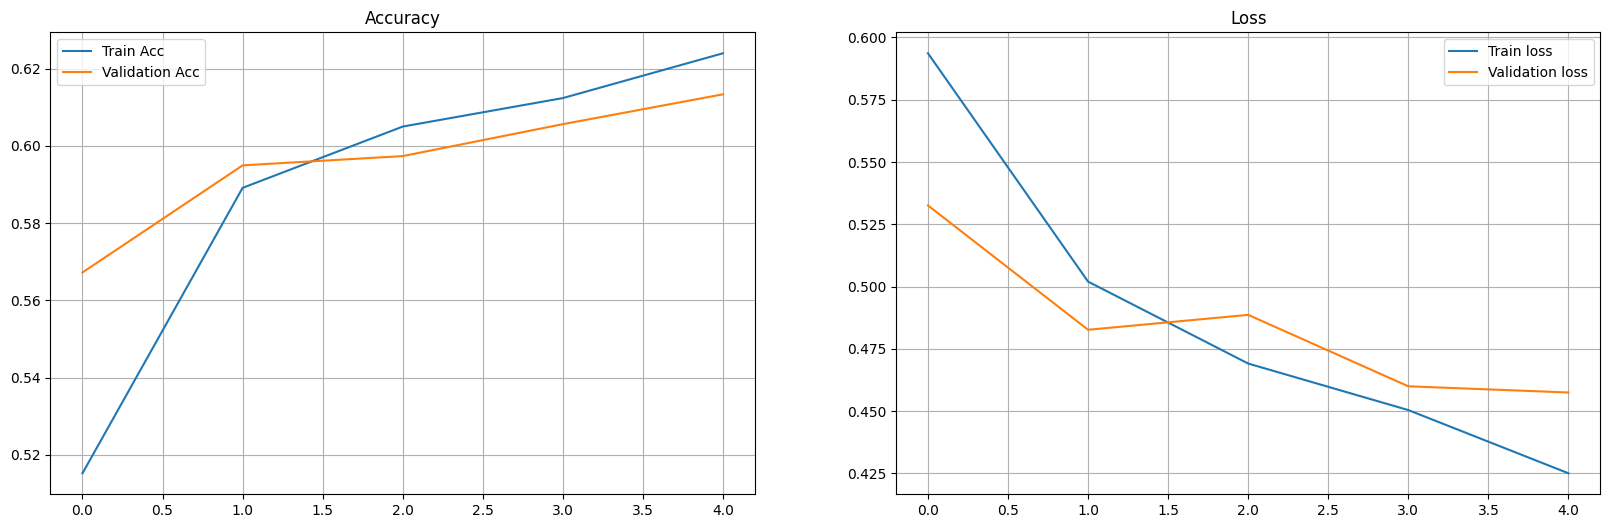

In [35]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [36]:
model_relu.eval()
test_losses = []
num_correct = 0
with torch.no_grad():
  test_h = model_relu.init_hidden(batch_size)
  for index, row in enumerate(test_loader):
          test_h = tuple([each.data for each in test_h])
          inputs, labels = inputs.to(device), labels.to(device)
          output, test_h = model_relu(inputs, test_h)
          predicted = torch.round(output.squeeze())
          loss = criterion((output), (labels).float())
          test_losses.append(loss.item())
          correct_tensor = predicted.eq(labels.float().view_as(predicted))
          correct = np.squeeze(correct_tensor.cpu().numpy())
          num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 0.5124
Test Accuracy: 0.64
